In [1]:
from mne import read_epochs, set_eeg_reference
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [2]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

# load_raw_to_epochs('m.bdf', True)

In [3]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\mrl\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
raw.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=2, scalings=10e-5, events=raw.events, picks=['eeg','eog'])

Marking bad chanels

In [4]:
bads = ['T7', 'PO7', 'PO4', 'EXG8', 'EXG7', 'EXG6', 'FCz', 'FC2', 'FC3', 'F6', 'EXG5', 'C1', 'FC5', 'F1', 'P1', 'F4', 'Oz']
raw.info['bads'] = bads
raw.drop([27, 48, 70, 99, 118, 119, 121])

Dropped 7 epochs: 27, 48, 70, 99, 118, 119, 121


<EpochsFIF |  120 events (all good), -2 - 7.99902 sec, baseline off, ~684.5 MB, data loaded,
 'r_pinch': 25
 'r_stop': 25
 'left': 24
 'right': 25
 'rest': 21>

Referencing

In [5]:
referenced = set_eeg_reference(raw,ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


set channel types

In [6]:
referenced.set_channel_types(get_channel_types())

<EpochsFIF |  120 events (all good), -2 - 7.99902 sec, baseline off, ~684.5 MB, data loaded,
 'r_pinch': 25
 'r_stop': 25
 'left': 24
 'right': 25
 'rest': 21>

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 4752 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 7680 out of 7680 | elapsed:   11.3s finished


Using matplotlib as 2D backend.


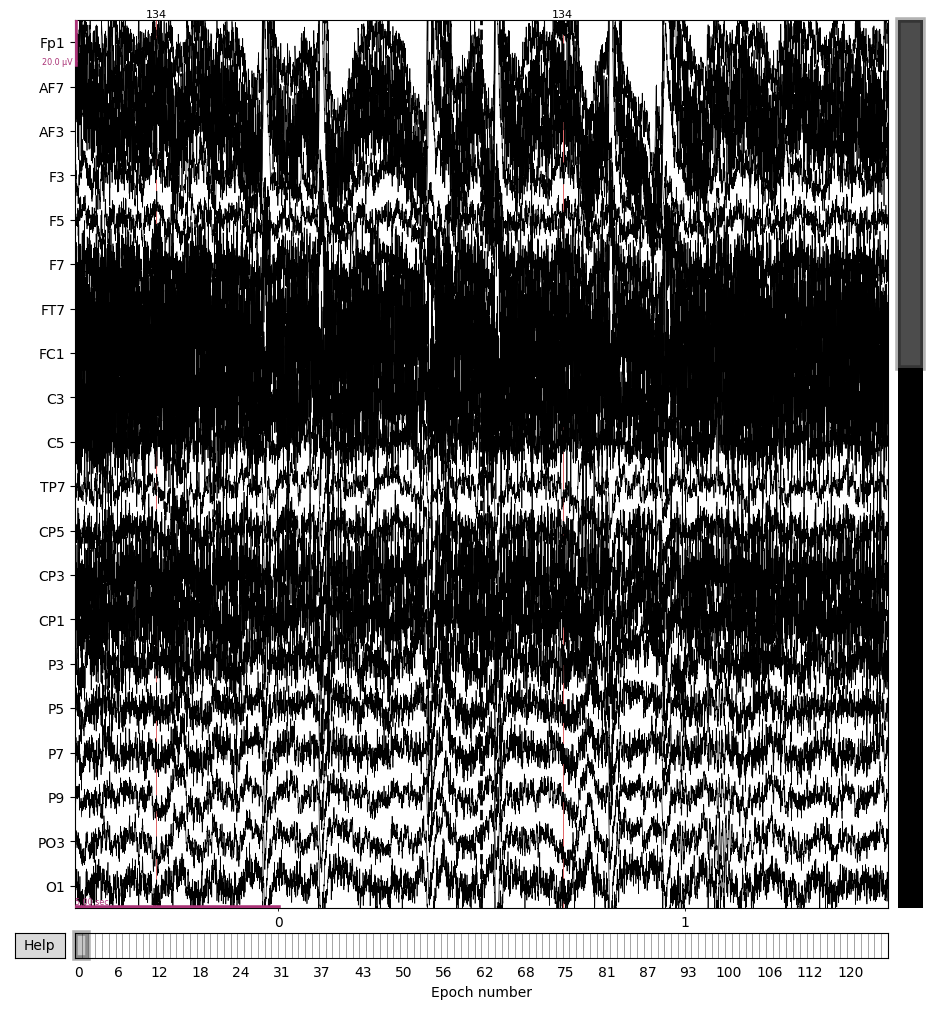

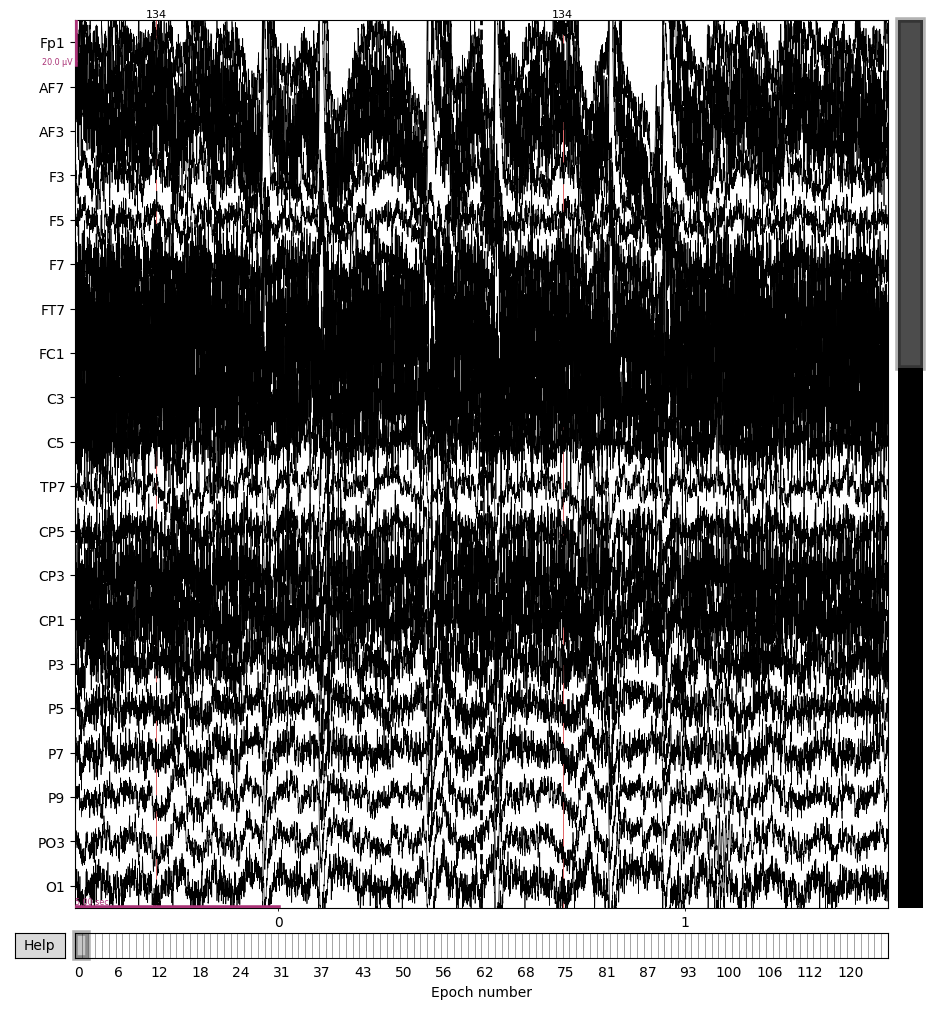

In [14]:
referenced.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=2, scalings=10e-6, events=referenced.events, picks=['eeg','ecg'])

EOG Regression


No projector specified for this dataset. Please consider the method self.add_proj.


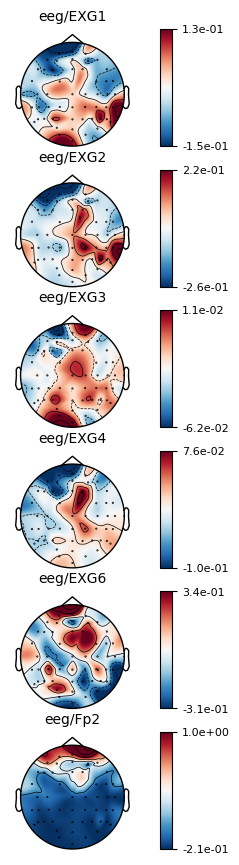

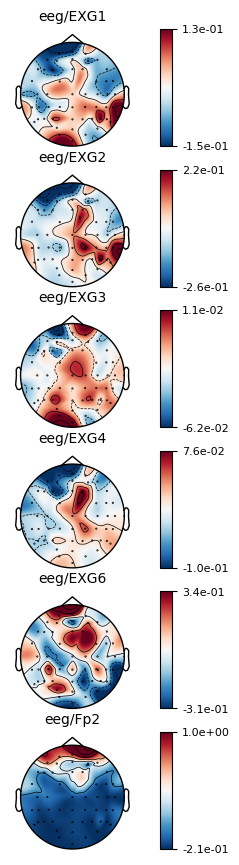

In [7]:
print()
emg_eog = ['EXG1','EXG2','EXG3','EXG4','EXG6','Fp2']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
regressor.plot()
# referenced = regressor.apply(referenced)
# referenced.info['bads'] += ['Fp2']

In [8]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [9]:
epochs = read_epochs('referenced_epo.fif')
# epochs.drop([0, 2, 47, 54, 55, 57, 66])

Reading C:\Users\Alberto\Documents\BCI\data\mrl\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


ICA

In [10]:
filtered = epochs.copy().filter(1,250, n_jobs=8)
filtered.apply_baseline((-1.4,-0.1))
filtered.crop(0,5)
ica = ICA(n_components=.9, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 427 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 5776 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 7680 out of 7680 | elapsed:   19.0s finished


Applying baseline correction (mode: mean)
Fitting ICA to data using 51 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_8484\3273349700.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by explained variance: 7 components
Fitting ICA took 24.0s.


<ICA | epochs decomposition, method: picard (fit in 48 iterations on 614520 samples), 7 ICA components (51 PCA components available), channel types: eeg, no sources marked for exclusion>

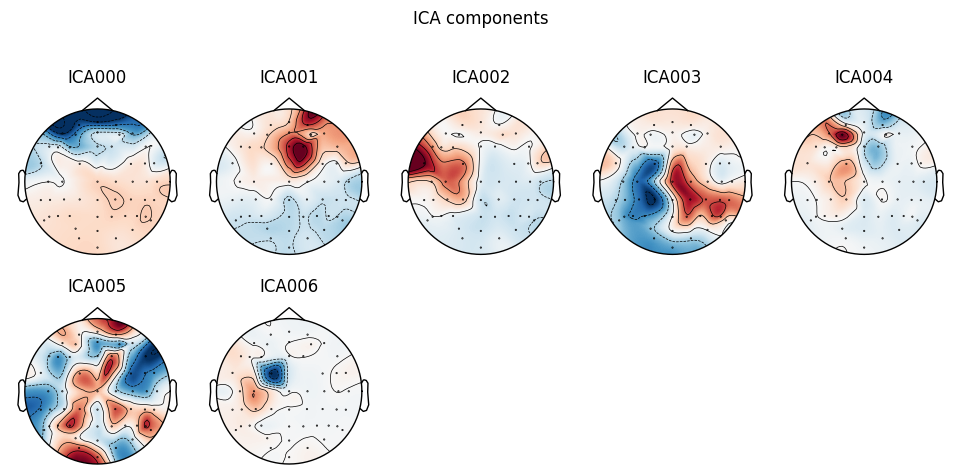

[<MNEFigure size 975x496 with 7 Axes>]

In [11]:
plot_ica_components(ica)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


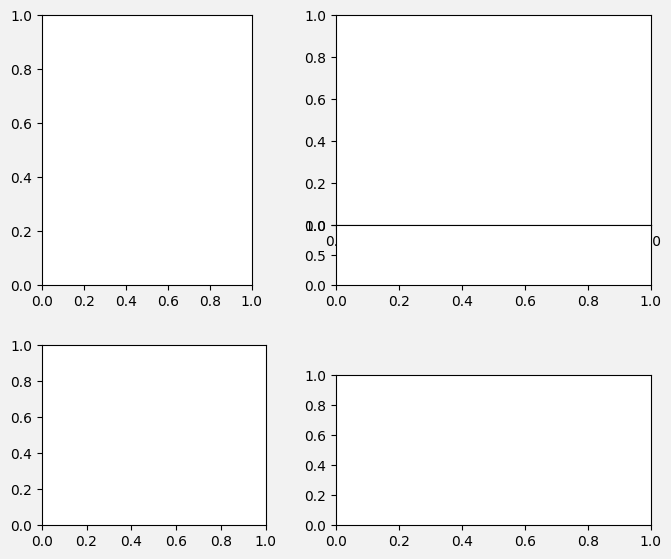

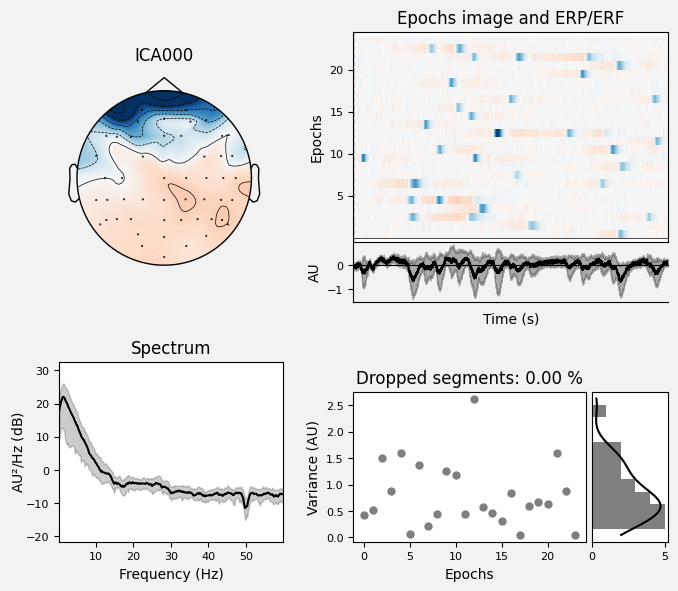

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


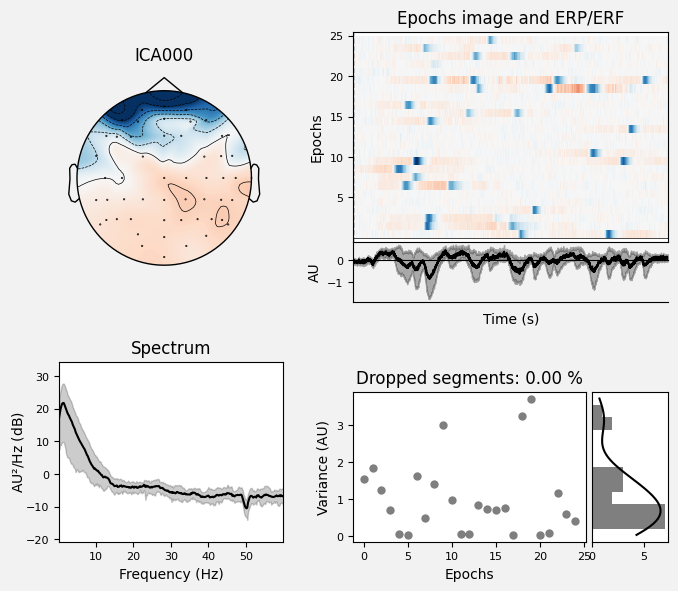

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


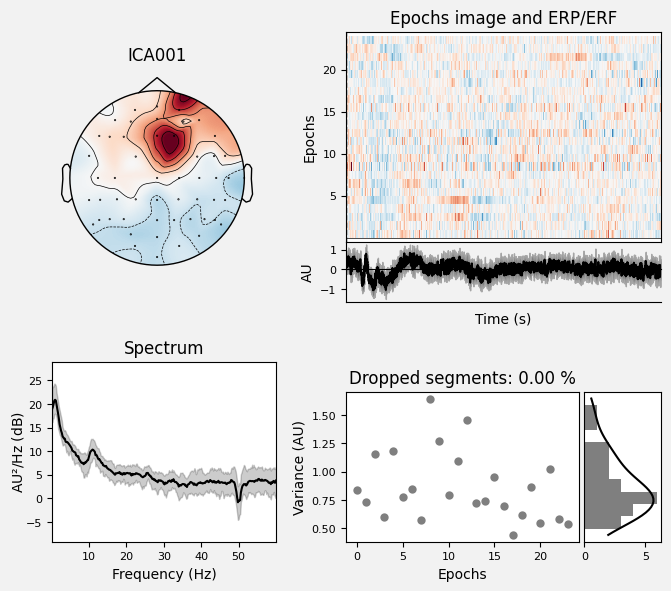

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


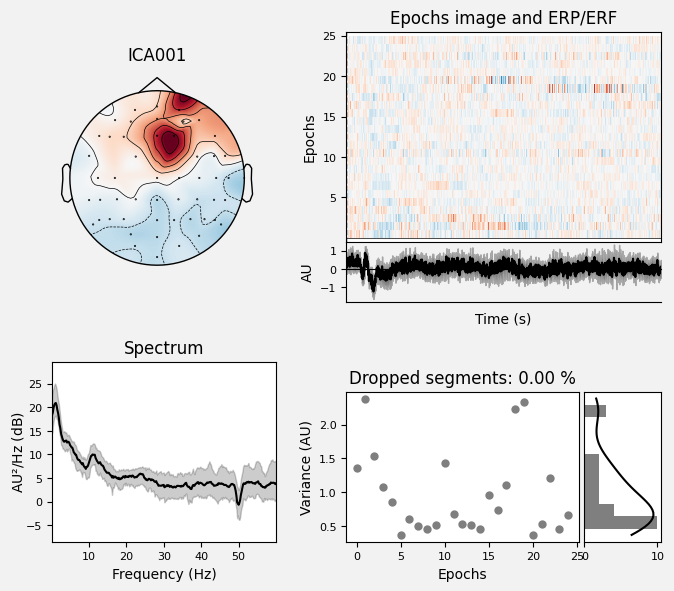

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


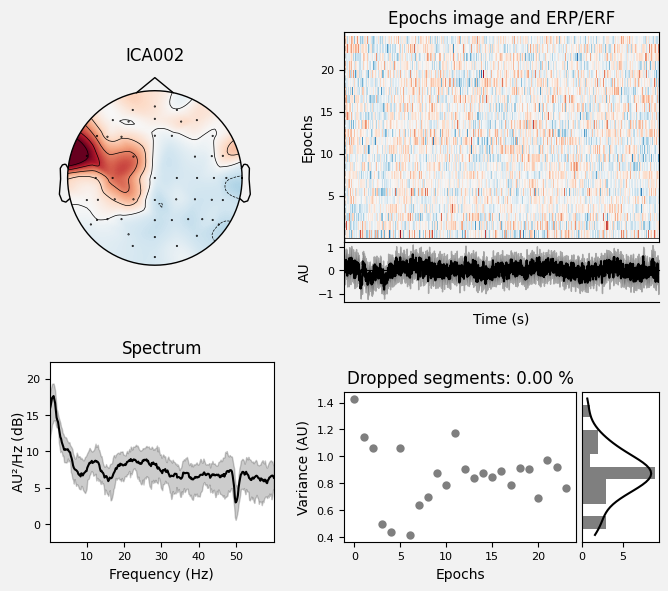

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


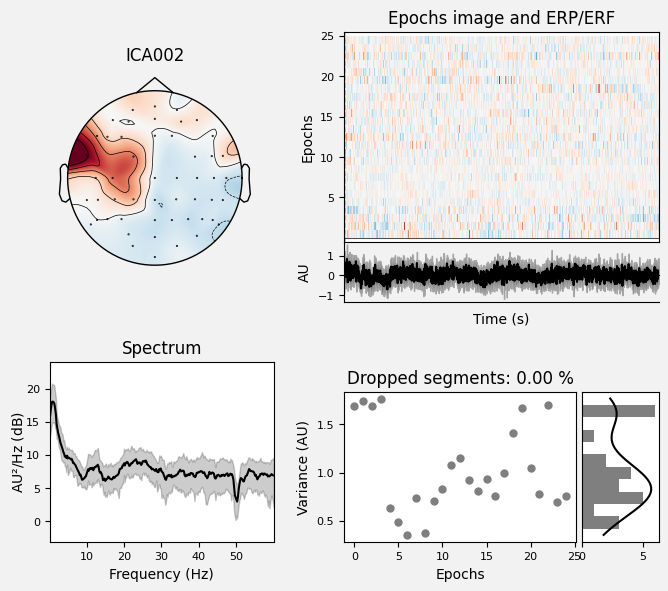

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


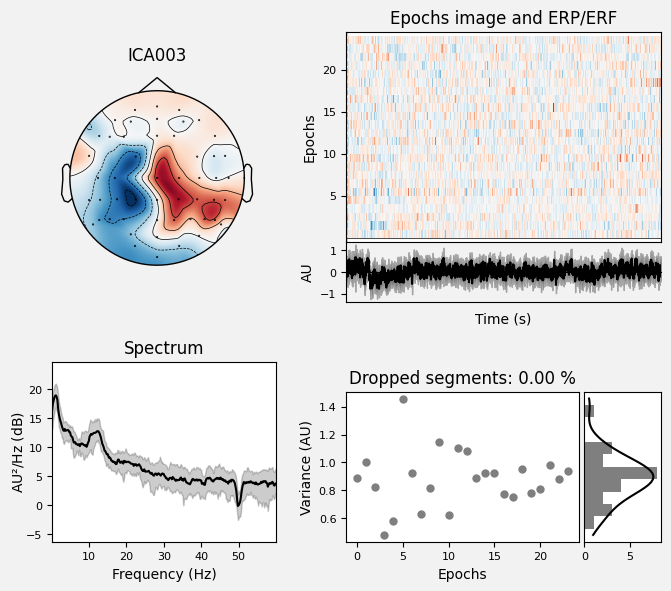

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


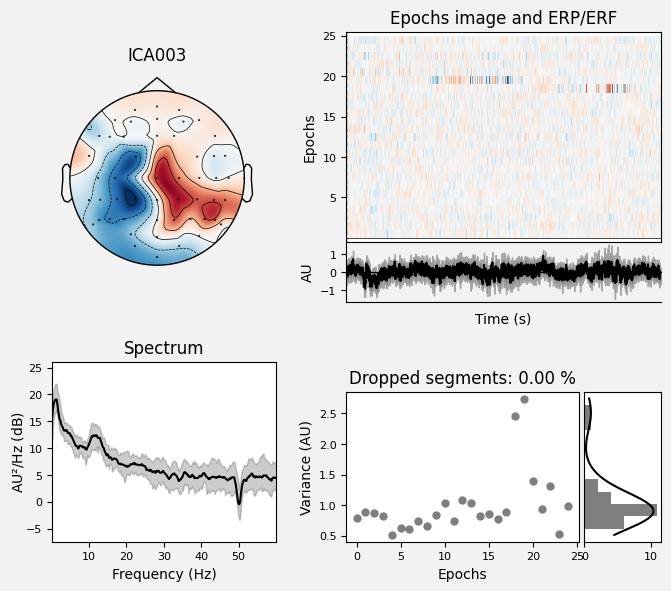

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


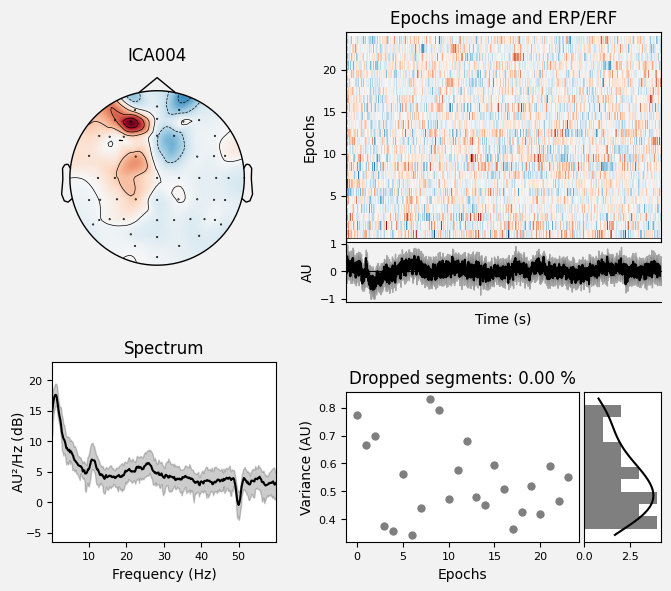

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


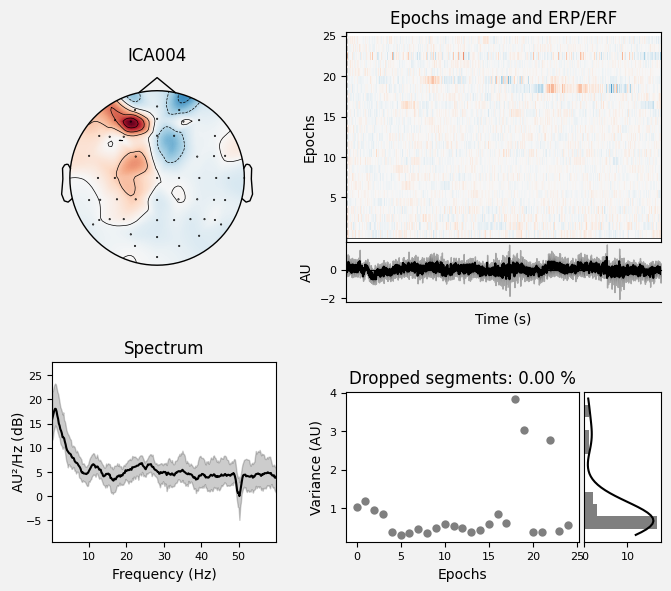

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


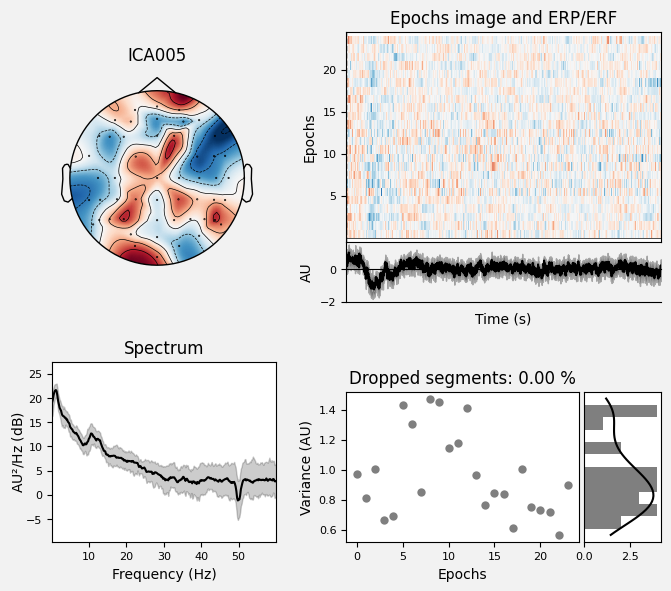

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


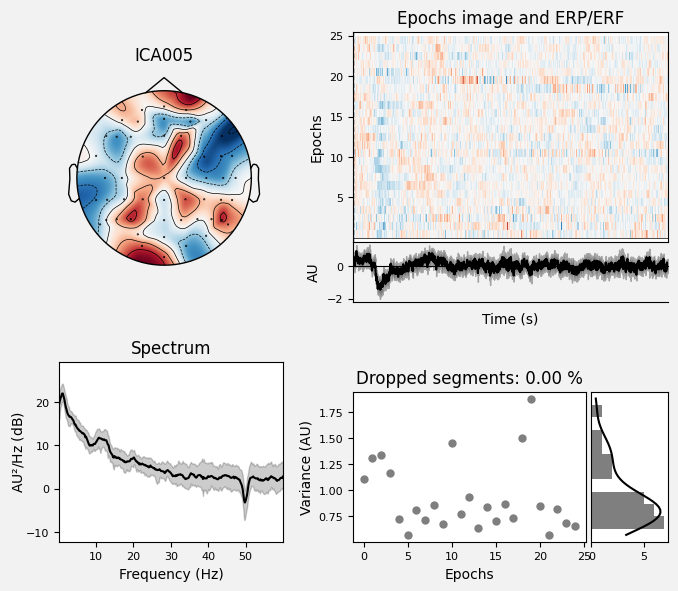

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated


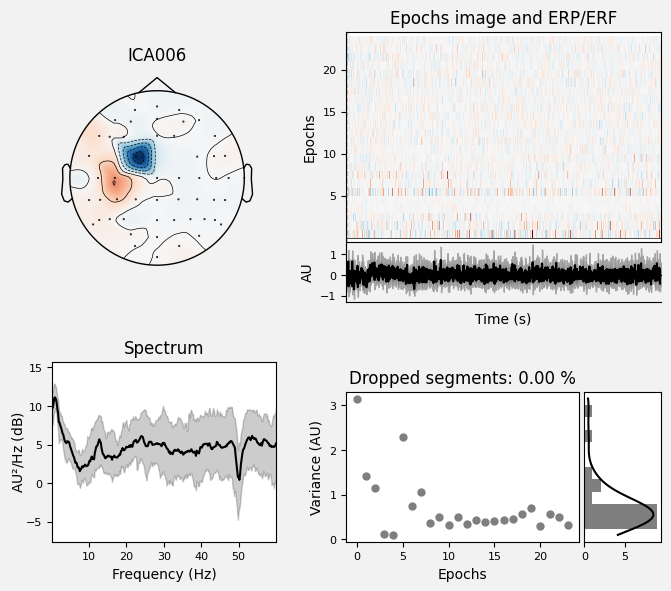

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


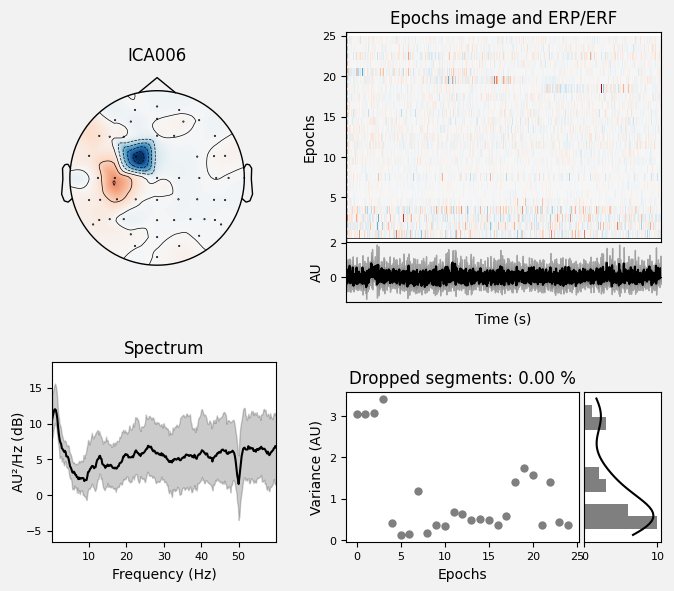

IndexError: index 7 is out of bounds for axis 1 with size 7

In [13]:
for i in np.arange(8):
    ica.plot_properties(
        epochs['left'].copy().crop(0,5).filter(1,240, verbose=False), 
        picks = [i], 
        log_scale = False,
        psd_args = dict(fmin=.1, fmax=60))

    ica.plot_properties(
        epochs['right'].copy().crop(0,5).filter(1,240, verbose=False), 
        picks = [i], 
        log_scale = False,
        psd_args = dict(fmin=.1, fmax=60))

In [14]:
ica.apply(epochs, exclude=np.unique([0,6]))

Applying ICA to Epochs instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 51 PCA components


<EpochsFIF |  120 events (all good), -2 - 7.99902 sec, baseline off, ~684.5 MB, data loaded,
 'r_pinch': 25
 'r_stop': 25
 'left': 24
 'right': 25
 'rest': 21>

ERP

Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_16948\1473548434.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (1435), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['rest'].copy().apply_baseline((-1.4, -1)).crop(.1,1.5).filter(1, 40).average().plot()
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1344 out of 1344 | elapsed:    0.7s finished


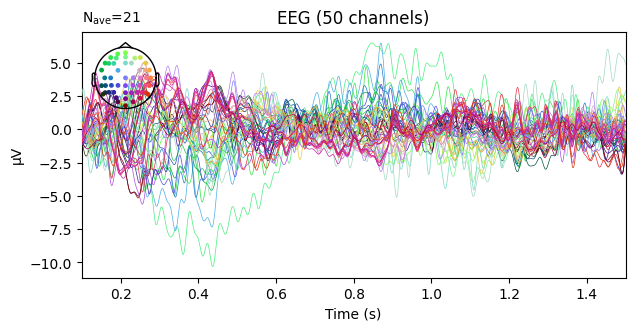

Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_16948\1473548434.py:2: RuntimeWarning: filter_length (3381) is longer than the signal (1435), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['right','left'].copy().apply_baseline((-1.4, -1)).crop(.1,1.5).filter(1, 40).average().plot()
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 3136 out of 3136 | elapsed:    1.9s finished


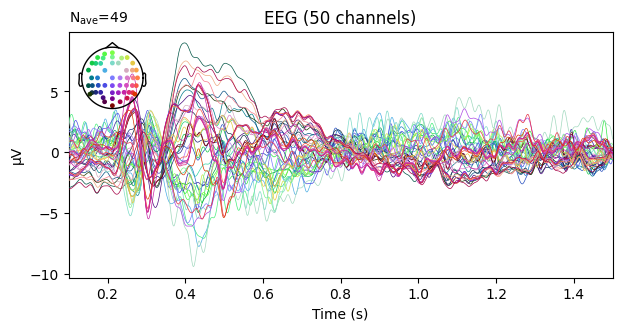

Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    2.4s finished


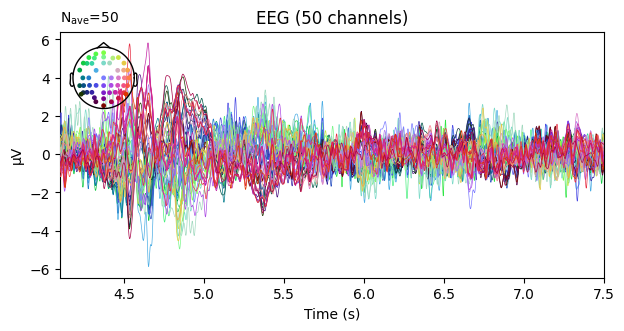

In [14]:
epochs['rest'].copy().apply_baseline((-1.4, -1)).crop(.1,1.5).filter(1, 40).average().plot()
epochs['right','left'].copy().apply_baseline((-1.4, -1)).crop(.1,1.5).filter(1, 40).average().plot()
epochs['r_pinch','r_stop'].copy().apply_baseline((-1.4, -1)).crop(4.1,7.5).filter(1, 40).average().plot()
print()

Setting up band-pass filter from 2 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 1691 samples (1.651 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 988 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1344 out of 1344 | elapsed:    0.4s finished


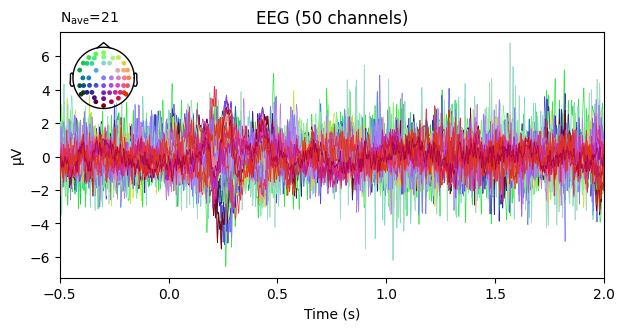

In [28]:
epochs['rest'].copy().crop(-0.5,2).filter(2,120, n_jobs=8).average().plot()
print()

In [15]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [16]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.


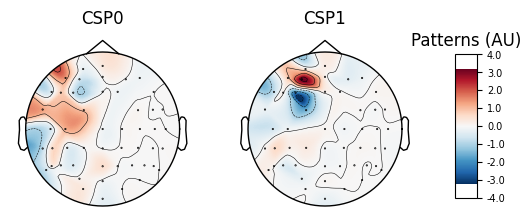

In [17]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.


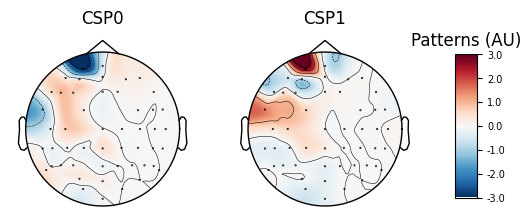

In [18]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.


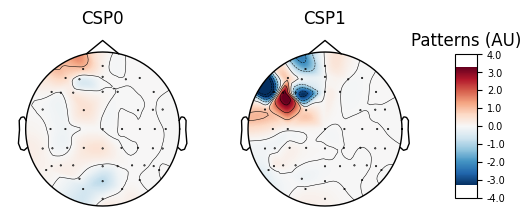

In [19]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [15]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.
